In [1]:
%load_ext autoreload
%autoreload 2

import pickle, os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from free_flyer import FreeFlyer

In [2]:
def findIC(obstacles, posmin, posmax, velmin, velmax):
    """ Given list of obstacles, find IC that is collision free"""
    IC_found = False
    while not IC_found:
        r0 = posmin + (posmax-posmin)*np.random.rand(2)
        if not any([r0[0] >= obstacle[0] and r0[0] <= obstacle[1] and \
             r0[1] >= obstacle[2] and r0[1] <= obstacle[3] \
             for obstacle in obstacles]):
            IC_found = True
    x0 = np.hstack((r0, velmin + (velmax-velmin)*np.random.rand(2)))
    return x0

In [3]:
def is_free_state(x0, obstacles, posmin, posmax):
    """ Check if x0 is free state given list of obstacles"""
    if any([x0[0] >= obstacle[0] and x0[0] <= obstacle[1] and \
             x0[1] >= obstacle[2] and x0[1] <= obstacle[3] \
             for obstacle in obstacles]):
        return False
    return True

In [4]:
def find_obs(x0, posmin, posmax, n_obs, max_iter=50):
    """ Given state x0, place obstacles between x0 and posmax"""
    obs = []
    itr = 0
    while len(obs) < n_obs and itr < max_iter:
        xmin = (posmax[0] - border_size - max_box_size)*np.random.rand() + border_size
        xmin = np.max([xmin, x0[0]])
        xmax = xmin + min_box_size  + (max_box_size - min_box_size)*np.random.rand()
        ymin = (posmax[1] - border_size - max_box_size)*np.random.rand() + border_size
        ymin = np.max([ymin, x0[1]])
        ymax = ymin + min_box_size  + (max_box_size - min_box_size)*np.random.rand()
        obstacle = np.array([xmin - box_buffer, xmax + box_buffer, \
                        ymin - box_buffer, ymax + box_buffer])
        if is_free_state(x0, [obstacle], posmin, posmax):
            obs.append(obstacle)
        itr += 1

    if len(obs) is not n_obs:
        return []
    return obs

In [5]:
def random_obs(n_obs, posmin, posmax, border_size, \
              min_box_size, max_box_size):
    """ Generate random list of obstacles in workspace """
    obstacles = []
    for ii in range(n_obs):
        xmin = (posmax[0] - border_size - max_box_size)*np.random.rand() + border_size
        xmax = xmin + min_box_size  + (max_box_size - min_box_size)*np.random.rand()
        ymin = (posmax[1] - border_size - max_box_size)*np.random.rand() + border_size
        ymax = ymin + min_box_size  + (max_box_size - min_box_size)*np.random.rand()
        obstacle = np.array([xmin - box_buffer, xmax + box_buffer, \
                            ymin - box_buffer, ymax + box_buffer])
        obstacles.append(obstacle)
    return obstacles

# Problem parameters

In [6]:
n = 2; m = 2

N = 6 # horizon
dh = 0.75
Ak = np.eye(2*n)
Ak[:n,n:] = dh*np.eye(n)
Bk = np.zeros((2*n,m))
Bk[:n,:] = 0.5*dh**2 * np.eye(n)
Bk[n:,:] = dh*np.eye(n)

Q = np.diag([2,2,1,1.])
R = 0.1*np.eye(m)

mass_ff_min = 15.36
mass_ff_max = 18.08
mass_ff = 0.5*(mass_ff_min+mass_ff_max)
thrust_max = 2*1.  # max thrust [N] from two thrusters 
umin = -thrust_max/mass_ff
umax = thrust_max/mass_ff
velmin = -0.2
velmax = 0.2
posmin = np.zeros(n)

ft2m = 0.3048
posmax = ft2m*np.array([12.,9.])
max_box_size = 0.75
min_box_size = 0.25
box_buffer = 0.025
border_size = 0.05

n_obs = 8

prob_params = [N, Ak, Bk, Q, R, n_obs , \
    posmin, posmax, velmin, velmax, umin, umax]

### Randomly sample obstacles and then find free x0

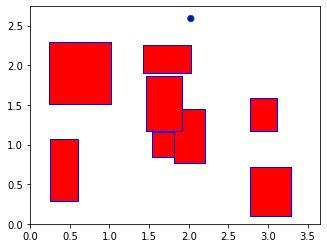

<Figure size 432x288 with 0 Axes>

In [7]:
obstacles = random_obs(n_obs, posmin, posmax, border_size, min_box_size, max_box_size)
x0 = findIC(obstacles, posmin, posmax, velmin, velmax)

plt.axes()
for obstacle in obstacles:
    rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                              obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                             fc='red', ec='blue')
    plt.gca().add_patch(rectangle)
    plt.axis('scaled')

circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
plt.gca().add_patch(circle)    

ax = plt.gca()
ax.margins(0)
ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
fig = plt.figure()
plt.show()

### Or sample x0 and place obstacles along the way to xg

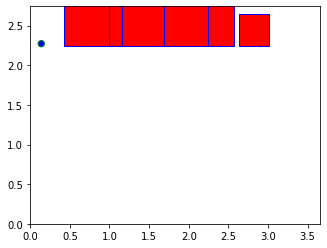

In [8]:
x0 = np.hstack((posmin + (posmax-posmin)*np.random.rand(2), \
               velmin + (velmax-velmin)*np.random.rand(2)))
obstacles = find_obs(x0, posmin, posmax, n_obs)

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
    plt.gca().add_patch(circle)    

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

### For obstacle map feature, shade in one particular obstacle

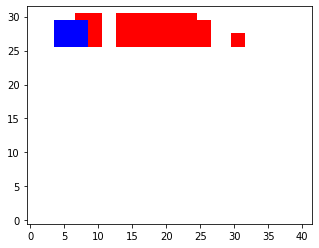

In [9]:
obs_ii = 7

W_H_ratio = posmax[0] / posmax[1]
H = 32
W = int(W_H_ratio * H)

table_img = np.ones((H,W,3))

obs_ll = [ii for ii in range(n_obs) if ii is not obs_ii]
obs_ll.append(obs_ii)
obs_ll
for ll in obs_ll:
    obs = obstacles[ll]
    row_range = range(int(float(obs[2])/posmax[1]*H), int(float(obs[3])/posmax[1]*H))
    col_range = range(int(float(obs[0])/posmax[0]*W), int(float(obs[1])/posmax[0]*W))
    row_range = range(np.maximum(row_range[0],0), np.minimum(row_range[-1],H))
    col_range = range(np.maximum(col_range[0],0), np.minimum(col_range[-1],W))

    if ll is obs_ii:
        table_img[row_range[0]:row_range[-1], col_range[0]:col_range[-1], :] = 1
        table_img[row_range[0]:row_range[-1], col_range[0]:col_range[-1], :2] = 0
    else:
        table_img[row_range[0]:row_range[-1], col_range[0]:col_range[-1], 1:] = 0

plt.imshow(table_img)
plt.gca().invert_yaxis()

# Setup pickle file for default parameters

In [16]:
#setup filenames
relative_path = os.getcwd()
dataset_name = 'default'

if not os.path.isdir(os.path.join(relative_path, 'data', dataset_name)):
    os.mkdir(os.path.join(relative_path+'/data/'+dataset_name))
    
if not os.path.isdir(os.path.join(relative_path, 'config')):
    os.mkdir(os.path.join(relative_path, 'config'))

train_fn = os.path.join(relative_path, 'data', dataset_name, 'train.p')
test_fn = os.path.join(relative_path, 'data', dataset_name, 'test.p')

#load default parameter values
n = 2; m = 2

#define all possible params that can be varied
all_params = ['N', 'Ak', 'Bk', 'Q', 'R', 'n_obs', \
    'posmin', 'posmax', 'velmin', 'velmax', \
    'umin', 'umax', \
    'x0', 'xg', 'obstacles']

## TODO(pculbertson): implement custom param variation.
#plan: split all_params into static & sampled params
#in Problem object, keep param dict with keys == all_params
#on constructing problem, make every param key map to either static value
#or a cvxpy.Parameter object.

### VARY ANY DESIRED PARAM VALUES HERE ###

param_dict = {'N':N, 'Ak':Ak, 'Bk':Bk, 'Q':Q, 'R':R, 'n_obs':n_obs, \
    'posmin':posmin, 'posmax':posmax, 'velmin':velmin, 'velmax':velmax, \
    'umin':umin, 'umax':umax}

#specify which parameters to sample, & their distributions
sampled_params = ['x0', 'xg', 'obstacles']
sample_dists = {'x0': lambda: np.hstack((posmin + (posmax-posmin)*np.random.rand(2), \
               velmin + (velmax-velmin)*np.random.rand(2))) ,\
               'xg': lambda: np.hstack((0.9*posmax, np.zeros(n))), \
               'obstacles': lambda: random_obs(n_obs, posmin, posmax, border_size, min_box_size, max_box_size)}

#specify dataset sizes
num_train = 90000; num_test = 10000
num_probs = num_train + num_test

#write out config
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

config = [dataset_name, prob_params, sampled_params]
outfile = open(config_fn,"wb")
pickle.dump(config,outfile); outfile.close()

# Generate training+test set data by solving MICPs

In [17]:
prob = FreeFlyer()

#create numpy containers for data: (params, x, u, y, J*, solve_time)
params = {}
if 'x0' in sampled_params:
    params['x0'] = np.zeros((num_probs,2*n))
if 'xg' in sampled_params:
    params['xg'] = np.zeros((num_probs,2*n))
if 'obstacles' in sampled_params:
    params['obstacles'] = np.zeros((num_probs, 4, n_obs))

X = np.zeros((num_probs, 2*n, N));
U = np.zeros((num_probs, m, N-1))
Y = np.zeros((num_probs, 4*n_obs, N-1)).astype(int)

costs = np.zeros(num_probs)
solve_times = np.zeros(num_probs)

In [18]:
total_count = 0
ii = 0
ii_obs = 0
ii_toggle = 0
obs_new_ct = 5
toggle_ct = 10
toggle_obstacles = True

#big for loop, sampling problem data, solving MICP, & storing
while ii < num_probs:
    total_count += 1
    if total_count % 10000 == 0:
        print('Done with problem {}'.format(ii))

    p_dict = {}
    if 'x0' in sampled_params or 'obstacles' in sampled_params:
        if toggle_obstacles:
            x0 = sample_dists['x0']()
            obstacles = find_obs(x0, posmin, posmax, n_obs)
            if len(obstacles) is not n_obs:
                continue

            if ii_toggle % obs_new_ct == 0:
                toggle_obstacles = False
                ii_obs = 0
                ii_toggle = 0

            params['x0'][ii,:] = x0
            params['obstacles'][ii,:] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
        else:
            if ii_obs % obs_new_ct == 0:
                obstacles = \
                    random_obs(n_obs, posmin, posmax, border_size, min_box_size, max_box_size)
            x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
            
            if ii_toggle % toggle_ct == 0:
                toggle_obstacles = True
                ii_obs = 0
                ii_toggle = 0

        params['obstacles'][ii,:] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
        params['x0'][ii,:] = x0

        p_dict['x0'] = params['x0'][ii,:]
        p_dict['obstacles'] = params['obstacles'][ii,:]

    if 'xg' in sampled_params:
        params['xg'][ii,:] = sample_dists['xg']()
        p_dict['xg'] = params['xg'][ii,:]
    
    try:
        prob_success, cost, solve_time, optvals = prob.solve_micp(p_dict)
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('mosek failed at '.format(ii))

    if prob_success:
        costs[ii] = cost; solve_times[ii] = solve_time
        X[ii,:,:], U[ii,:,:], Y[ii,:,:] = optvals
        ii += 1
        ii_obs += 1
        ii_toggle += 1

Done with problem 8893
Done with problem 17669
Done with problem 26547
Done with problem 35380
Done with problem 44148
Done with problem 52934
Done with problem 61800
Done with problem 70634
Done with problem 79465
Done with problem 88242
Done with problem 97049


In [19]:
print('done')

done


### Data generated with spatial relations, so shuffle indices

In [20]:
arr = np.arange(num_probs)
np.random.shuffle(arr)

X = X[arr]
U = U[arr]
Y = Y[arr]

if 'x0' in sampled_params:
    params['x0'] = params['x0'][arr]
if 'xg' in sampled_params:
    params['xg'] = params['xg'][arr]
if 'obstacles' in sampled_params:
    params['obstacles'] = params['obstacles'][arr]

costs = costs[arr]
solve_times = solve_times[arr]

In [21]:
#post-processing + write out
train_params = {}; test_params = {}
if 'x0' in sampled_params:
    train_params['x0'] = params['x0'][:num_train,:]
    test_params['x0'] = params['x0'][num_train:,:]
if 'obstacles' in sampled_params:
    train_params['obstacles'] = params['obstacles'][:num_train,:]
    test_params['obstacles'] = params['obstacles'][num_train:,:]
if 'xg' in sampled_params:
    train_params['xg'] = params['xg'][:num_train,:]
    test_params['xg'] = params['xg'][num_train:,:]

train_data = [train_params]
train_data += [X[:num_train,:,:], U[:num_train,:,:], Y[:num_train,:,:]]
train_data += [costs[:num_train], solve_times[:num_train]]

test_data = [test_params]
test_data += [X[num_train:,:,:], U[num_train:,:,:], Y[num_train:,:,:]]
test_data += [costs[num_train:], solve_times[num_train:]]

train_file = open(train_fn,'wb')
pickle.dump(train_data,train_file); train_file.close()

test_file = open(test_fn, 'wb')
pickle.dump(test_data,test_file); test_file.close()

In [ ]:
train_file = open(train_fn,'rb')
p, x, u, y, c, s = pickle.load(train_file); train_file.close()

In [ ]:
idx = np.random.randint(train_data[1].shape[0])

obstacles = []
for ii_obs in range(n_obs):
    obs = train_data[0]['obstacles'][idx][:,ii_obs]
    obstacles.append(obs)

x0 = train_data[0]['x0'][idx]
# x0 = findIC(obstacles, posmin, posmax, velmin, velmax)

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
    plt.gca().add_patch(circle)    

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

In [ ]:
# shitty = True
# x0, obstacles = None, None
# while shitty:
#     obstacles = random_obs(n_obs, posmin, posmax, border_size, min_box_size, max_box_size)
#     x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
#     if all([x0[0] <= obstacle[0] and x0[0] <= obstacle[1] and \
#                  x0[1] <= obstacle[2] and x0[1] <= obstacle[3] for obstacle in obstacles]):
#         shitty = False
# obstacles = random_obs(n_obs, posmin, posmax, border_size, min_box_size, max_box_size)
# x0 = findIC(obstacles, posmin, posmax, velmin, velmax)

# if len(obstacles) is n_obs:
#     plt.axes()
#     for obstacle in obstacles:
#         rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
#                                   obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
#                                  fc='red', ec='blue')
#         plt.gca().add_patch(rectangle)
#         plt.axis('scaled')

#     circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
#     plt.gca().add_patch(circle)   

#     ax = plt.gca()
#     ax.margins(0)
#     ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
#     plt.show()

In [ ]:
# prob.init_bin_problem()

# p_dict = {}
# p_dict['x0'] = x0
# p_dict['obstacles'] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
# p_dict['xg'] = sample_dists['xg']()

# prob_success, cost, solve_time, optvals = prob.solve_micp(p_dict)
# prob_success

In [ ]:
# X = optvals[0]

# plt.axes()
# for obstacle in obstacles:
#     rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
#                               obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
#                              fc='red', ec='blue')
#     plt.gca().add_patch(rectangle)
#     plt.axis('scaled')

# for jj in range(N):
#     circle = plt.Circle((X[0,jj],X[1,jj]), 0.04, fc='blue',ec="blue")
#     plt.gca().add_patch(circle)   
    
# xg = p_dict['xg']
# circle = plt.Circle((xg[0],xg[1]), 0.04, fc='red',ec="red")
# plt.gca().add_patch(circle)   

# ax = plt.gca()
# ax.margins(0)
# ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
# plt.show()